# IBM Data Science Capstone Project - Auckland Bookstore

In this notebook, we will be covering step by step the process to determine an optimal location for a new bookstore in the city of Auckland, New Zealand. We're going to use Machine Learning tools such as K-means in order to obtain clusters of potential locations. Data wrangling and preprocessing will also be necessary to structure the data properly and to facilitate the analysis.

### I. Data Preparation

First of all, let's import some dependencies that we will use.

In [1]:
import numpy as np
import pandas as pd
import json
import requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium

!conda install -c conda-forge geocoder --yes
import geocoder

!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim

!conda install -c conda-forge beautifulsoup4 --yes
from bs4 import BeautifulSoup

%matplotlib inline

print("Libraries imported.")

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geocoder


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    brotlipy-0.7.0             |py36h8c4c3a4_1000         346 KB  conda-forge
    chardet-3.0.4              |py36h9f0ad1d_1006         188 KB  conda-forge
    click-7.1.2                |     pyh9f0ad1d_0          64 KB  conda-forge
    cryptography-2.9.2         |   py36h45558ae_0         613 KB  conda-forge
    future-0.18.2              |   py36h9f0ad1d_1         714 KB  conda-forge
    geocoder-1.38.1            |             py_1          53 KB  conda-forge
    pysocks-1.7.1              |   py36h9f0ad1d_1          27 KB  conda-forge
    ratelim-0.1.6              |             py_2           6 KB  conda-forge
    requests-2.24.0            |     pyh9f0ad1d_0          47 KB  conda-forge
    -

With the help of the beautiful soup package, we will obtain the data of Auckland's suburbs from: https://en.wikipedia.org/wiki/Category:Suburbs_of_Auckland

In [2]:
source = requests.get('https://en.wikipedia.org/wiki/Category:Suburbs_of_Auckland').text 
soup = BeautifulSoup(source,'html.parser')

In [3]:
NeighbourhoodList = []
for row in soup.find_all('div', class_='mw-category')[0].findAll('li'):
    NeighbourhoodList.append(row.text)

Let's convert the information into a pandas dataframe.

In [4]:
Neighbourhood_df = pd.DataFrame({'Neighbourhood': NeighbourhoodList})
print(Neighbourhood_df.shape)
Neighbourhood_df.head()

(200, 1)


,Neighbourhood
0,List of suburbs of Auckland
1,Airport Oaks
2,"Albany, New Zealand"
3,"Alfriston, New Zealand"
4,Algies Bay


Now that we visualize the dataframe, it seems that our first row shows redundant information. Let's proceed to drop said row.

In [5]:
Neighbourhood_df = Neighbourhood_df.loc[1:]
print(Neighbourhood_df.shape)
Neighbourhood_df.head()

(199, 1)


,Neighbourhood
1,Airport Oaks
2,"Albany, New Zealand"
3,"Alfriston, New Zealand"
4,Algies Bay
5,"Arch Hill, New Zealand"


Let's define a function to obtain the coordinates of the neighbourhoods in Auckland.

In [6]:
def get_latlng(Neighbourhood):
    # Initialize variable to None
    lat_lng_coords = None
    # Loop until we get the coordinates
    while(lat_lng_coords is None):
        g = geocoder.arcgis('{}, Auckland, New Zealand'.format(Neighbourhood))
        lat_lng_coords = g.latlng
    return lat_lng_coords

In [7]:
coordinates = [get_latlng(Neighbourhood) for Neighbourhood in Neighbourhood_df['Neighbourhood'].tolist()]
coordinates[0:5]

[[-36.79358936514173, 174.6180114282607],
 [-36.72915999999998, 174.70893000000012],
 [-37.010493372999974, 174.9408516090001],
 [-36.84839904099994, 174.76438785300002],
 [-36.86301999999995, 174.74858000000006]]

After obtaining the coordinates, we will merge them with the original dataframe.

In [8]:
latlong_df = pd.DataFrame(coordinates, columns=['Latitude', 'Longitude'])

Neighbourhood_df['Latitude'] = latlong_df['Latitude']
Neighbourhood_df['Longitude'] = latlong_df['Longitude']

print(Neighbourhood_df.shape)
Neighbourhood_df.head()

(199, 3)


,Neighbourhood,Latitude,Longitude
1,Airport Oaks,-36.729160,174.708930
2,"Albany, New Zealand",-37.010493,174.940852
3,"Alfriston, New Zealand",-36.848399,174.764388
4,Algies Bay,-36.863020,174.748580
5,"Arch Hill, New Zealand",-36.847862,174.737085


Great! It looks complete. However, it is important to check if any rows have been left without their coordinate.

In [9]:
print("Num of rows with missing Longitude: ", Neighbourhood_df.Longitude.isna().sum())

Num of rows with missing Longitude:  1


In [10]:
print("Num of rows with missing Latitude: ", Neighbourhood_df.Latitude.isna().sum())

Num of rows with missing Latitude:  1


It seems that we have only one row with missing values. Let's drop that row so it won't affect our analysis.

In [11]:
Neighbourhood_df = Neighbourhood_df[Neighbourhood_df.Longitude.isna() == False]
Neighbourhood_df.shape

(198, 3)

Once we arranged our dataframe, why don't we visualize the map of Auckland along with its neighbourhoods? Let's obtain the coordinates of Auckland.

In [12]:
address = 'Auckland, New Zealand'

geolocator = Nominatim(user_agent='my-application')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

print('The geograpical coordinate of Auckland, New Zealand is latitude: {} and longitude: {}.'.format(latitude, longitude))

The geograpical coordinate of Auckland, New Zealand is latitude: -36.852095 and longitude: 174.7631803.


Let's create the map using all coordinates. We can navigate through this map and see the different locations of the city.

In [13]:
# Create map of Auckland using latitude and longitude values
map_auckland = folium.Map(location = [latitude, longitude], zoom_start=10)

# Add markers to map
for lat, lng, Neighbourhood in zip(Neighbourhood_df['Latitude'], Neighbourhood_df['Longitude'], Neighbourhood_df['Neighbourhood']):
    label = '{}'.format(Neighbourhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng], radius = 5, popup = label, color = 'blue', fill = True, fill_color = '#3186cc', fill_opacity = 0.7,
        parse_html = False).add_to(map_auckland)  
    
map_auckland

### II. Neighborhood Data (Foursquare)

Everything looks good, now we need to make use of the Foursquare API to obtain the venues that exist in each neighbourhood. Let's assign our credentials to some variables.

In [14]:
# Define Foursquare Credentials and Version
CLIENT_ID = 'CLIENT_ID'
CLIENT_SECRET = 'CLIENT_SECRET'
VERSION = '20180605'

Let's create a function that returns the characteristics of the venues so we can add them to our neighbourhoods dataframe. For this case, we will consider a radius of 3 km around the coordinate of each neighbourhood. In addition, we will only consider the hundred venues closest to said coordinates.

In [15]:
radius = 3000
limit = 100

def getNearbyVenues(names, latitudes, longitudes, radius = 3000):
    
    venues_list = []
    for name, lat, lng in zip(names, latitudes, longitudes):
        try:
            print(name)
            
            # Create the API request URL
            url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
                CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, limit)

            # Make the GET request
            results = requests.get(url).json()['response']['groups'][0]['items']

            # Return only relevant information for each nearby venue
            venues_list.append([(name, lat, lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])
        
        except KeyError:
            pass

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [16]:
auckland_venues = getNearbyVenues(names = Neighbourhood_df['Neighbourhood'],
                                 latitudes = Neighbourhood_df['Latitude'],
                                 longitudes = Neighbourhood_df['Longitude'])

Airport Oaks
Albany, New Zealand
Alfriston, New Zealand
Algies Bay
Arch Hill, New Zealand
Ardmore, New Zealand
Army Bay
Auckland CBD
Auckland waterfront
Avondale, Auckland
Balmoral, New Zealand
Bayswater, New Zealand
Bayview, New Zealand
Beach Haven, New Zealand
Belmont, Auckland
Birkdale, New Zealand
Birkenhead, New Zealand
Blockhouse Bay
Botany Downs
Brookby
Browns Bay, New Zealand
Bucklands Beach
Campbells Bay
Castor Bay
Chapel Downs
Chatswood, New Zealand
Cheltenham, New Zealand
Clendon Park
Clevedon, New Zealand
Clover Park
Cockle Bay, New Zealand
Conifer Grove
Crown Hill, New Zealand
Dannemora, New Zealand
Devonport, New Zealand
Duders Point
East Coast Bays
East Tamaki
Eastern Beach, New Zealand
Eden Terrace
Eden Valley, New Zealand
Ellerslie, New Zealand
Epsom, New Zealand
Fairview Heights, New Zealand
Farm Cove, New Zealand
Favona
Flat Bush
Forrest Hill, New Zealand
Freemans Bay
The Gardens, Auckland
Glen Eden, New Zealand
Glen Innes, New Zealand
Glendene, New Zealand
Glendowie

Next, let's look at our new dataframe. It must contain not only the coordinates, but also the information regarding the venues in each neighbourhood.

In [17]:
print(auckland_venues.shape)
auckland_venues.head()

(10696, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Airport Oaks,-36.72916,174.70893,K-Mart,-36.728644,174.709722,Department Store
1,Airport Oaks,-36.72916,174.70893,QBE Stadium,-36.726937,174.702059,Stadium
2,Airport Oaks,-36.72916,174.70893,The Merchant Bar & Kitchen,-36.727810,174.709088,Bar
3,Airport Oaks,-36.72916,174.70893,Event Cinemas,-36.728335,174.708643,Movie Theater
4,Airport Oaks,-36.72916,174.70893,Albany Mega Centre,-36.731220,174.706719,Shopping Mall


In [76]:
auckland_venues.groupby(['Neighbourhood']).count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Airport Oaks,55,55,55,55,55,55
"Albany, New Zealand",4,4,4,4,4,4
"Alfriston, New Zealand",100,100,100,100,100,100
Algies Bay,100,100,100,100,100,100
"Arch Hill, New Zealand",100,100,100,100,100,100
...,...,...,...,...,...,...
Waikowhai,14,14,14,14,14,14
Waima,41,41,41,41,41,41
Ōpaheke,89,89,89,89,89,89


Perfect! Why don't we check some of the venues categories?

In [18]:
print('There are {} uniques categories of venues.'.format(len(auckland_venues['Venue Category'].unique())))
auckland_venues['Venue Category'].unique()[:50]

There are 236 uniques categories of venues.


array(['Department Store', 'Stadium', 'Bar', 'Movie Theater',
       'Shopping Mall', 'Sushi Restaurant', 'Supermarket',
       'Bubble Tea Shop', 'Grocery Store', 'Multiplex', 'Burger Joint',
       'Furniture / Home Store', 'Café', 'Hockey Field', 'Coffee Shop',
       'Fast Food Restaurant', 'Portuguese Restaurant', 'Park',
       'Gourmet Shop', 'Juice Bar', 'Gym Pool', 'American Restaurant',
       'Athletics & Sports', 'Electronics Store', 'Seafood Restaurant',
       'Garden Center', 'Restaurant', 'Miscellaneous Shop',
       'Mexican Restaurant', 'Sandwich Place', 'Asian Restaurant',
       'Tea Room', 'Gym', 'Arts & Crafts Store', 'Garden',
       'Deli / Bodega', 'Bakery', 'Pizza Place', 'Food Court',
       'Dessert Shop', 'Art Gallery', 'Theater', 'Indian Restaurant',
       'Steakhouse', 'Bistro', 'Pub', 'Bagel Shop',
       'Brazilian Restaurant', 'Hotel', 'Frozen Yogurt Shop'],
      dtype=object)

### III. CLustering

Now, we will cluster the neighbourhoods to see which ones have similar surroundings. But before we begin, let's do one-hot encoding for the Venue Category column to convert this neighbourhoods to features.

In [19]:
# One hot encoding
auckland_1hot = pd.get_dummies(auckland_venues['Venue Category'], prefix="", prefix_sep="")
# Add neighborhood column back to dataframe
auckland_1hot['Neighbourhood'] = auckland_venues['Neighbourhood'] 
# Move neighborhood column to the first column
fixed_columns = [auckland_1hot.columns[-1]] + list(auckland_1hot.columns[:-1])
auckland_1hot = auckland_1hot[fixed_columns]

print(auckland_1hot.shape)
auckland_1hot.head()

(10696, 237)


,Neighbourhood,African Restaurant,Airport,Airport Lounge,Airport Service,American Restaurant,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,...,Vietnamese Restaurant,Volcano,Water Park,Wine Bar,Wine Shop,Winery,Women's Store,Yakitori Restaurant,Yoga Studio,Zoo
0,Airport Oaks,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Airport Oaks,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Airport Oaks,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Airport Oaks,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Airport Oaks,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


OK, now let's group the rows by neighbourhood. To this effect, let's use the mean of the frequency of occurrence of each category.

In [20]:
auckland_mean = auckland_1hot.groupby(['Neighbourhood']).mean().reset_index()
print(auckland_mean.shape)
auckland_mean.head()

(193, 237)


,Neighbourhood,African Restaurant,Airport,Airport Lounge,Airport Service,American Restaurant,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,...,Vietnamese Restaurant,Volcano,Water Park,Wine Bar,Wine Shop,Winery,Women's Store,Yakitori Restaurant,Yoga Studio,Zoo
0,Airport Oaks,0.0,0.0,0.0,0.0,0.018182,0.0,0.0,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
1,"Albany, New Zealand",0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
2,"Alfriston, New Zealand",0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.01,0.01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
3,Algies Bay,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.01,0.01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01
4,"Arch Hill, New Zealand",0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.01,0.01,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01


Great! We obtained a more structured table. However, don't forget that for the purpose of this project, it is only in our interest to analyze the neighborhoods that contain bookstores, so it is important to filter our dataset.

In [21]:
len(auckland_mean[auckland_mean["Bookstore"] > 0])

23

It seems that only 23 neighbourhoods in Auckland have bookstores. That is, considering the predetermined maximun number of venues and the radius that we defined before, and also the information we got from Foursquare. Of course, changing these values will result in a difference in the number of neighbourhoods containing bookstores. Now we can look at our bookstore only dataframe.

In [22]:
auckland_bookstore = auckland_mean[auckland_mean["Bookstore"] > 0]
print(auckland_bookstore.shape)
auckland_bookstore

(23, 237)


,Neighbourhood,African Restaurant,Airport,Airport Lounge,Airport Service,American Restaurant,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,...,Vietnamese Restaurant,Volcano,Water Park,Wine Bar,Wine Shop,Winery,Women's Store,Yakitori Restaurant,Yoga Studio,Zoo
9,"Avondale, Auckland",0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0
19,Brookby,0.0,0.0,0.0,0.0,0.010000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.01,0.0
25,"Chatswood, New Zealand",0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0
30,"Cockle Bay, New Zealand",0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0
33,"Dannemora, New Zealand",0.0,0.0,0.0,0.0,0.000000,0.012195,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0
34,"Devonport, New Zealand",0.0,0.0,0.0,0.0,0.000000,0.024390,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0
40,"Ellerslie, New Zealand",0.0,0.0,0.0,0.0,0.010000,0.000000,0.000000,0.0,0.010000,...,0.010000,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.00,0.0
66,"Herne Bay, New Zealand",0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,...,0.108108,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0
71,"Hillpark, Auckland",0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.017241,...,0.000000,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0
90,Manukau,0.0,0.0,0.0,0.0,0.010000,0.000000,0.000000,0.0,0.010000,...,0.010000,0.0,0.0,0.0,0.01,0.0,0.0,0.0,0.00,0.0


In order to enrich our analysis, let's define a function so we can observe the top 10 venues for each neighbourhood.

In [23]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

Let's create another dataframe to visualize the popular venues. Don't forget that we still need the above dataframe for the clustering.

In [24]:
num_top_venues = 10
indicators = ['st', 'nd', 'rd']

# Create columns according to number of top venues
column = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        column.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        column.append('{}th Most Common Venue'.format(ind+1))

# Create a new dataframe
venues_sorted = pd.DataFrame(columns = column)
venues_sorted['Neighbourhood'] = auckland_bookstore['Neighbourhood']

for ind in np.arange(auckland_bookstore.shape[0]):
    venues_sorted.iloc[ind, 1:] = return_most_common_venues(auckland_bookstore.iloc[ind, :], num_top_venues)

print(venues_sorted.shape)
venues_sorted.head()

(23, 11)


,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,"Avondale, Auckland",Café,Chinese Restaurant,Bar,Coffee Shop,Bakery,Gym,Park,Indian Restaurant,Burger Joint,Asian Restaurant
19,Brookby,Café,Fast Food Restaurant,Beach,Coffee Shop,Neighborhood,Burger Joint,Japanese Restaurant,Supermarket,Indian Restaurant,Bar
25,"Chatswood, New Zealand",Café,Scenic Lookout,Beach,Bar,History Museum,Bakery,Performing Arts Venue,Comfort Food Restaurant,Candy Store,Burger Joint
30,"Cockle Bay, New Zealand",Café,Park,Clothing Store,Grocery Store,Fast Food Restaurant,Farm,Rental Car Location,Juice Bar,Sporting Goods Shop,Motel
33,"Dannemora, New Zealand",Café,Hotel,Bar,Beach,Harbor / Marina,Restaurant,Coffee Shop,Pizza Place,Turkish Restaurant,Japanese Restaurant


Well it looks like Cafés are everywhere nowadays. Cool, I love them!

It is time to cluster our neighbourhoods by the similarity of venues. K-means is the method that we will use for that. But, first of all, let's drop the first column of the one-hot dataframe that contains only neighbourhoods with bookstores, since it isn't necessary for the culstering.

In [25]:
auckland_clustering = auckland_bookstore.drop('Neighbourhood', 1)

Oops, I forgot to import pyplot at the beginning. Well, as they say, is never too late, I am right? ;)

In [26]:
import matplotlib.pyplot as plt

def plot(x, y, xlabel, ylabel):
    plt.figure(figsize = (20,10))
    plt.plot(np.arange(2, x), y, 'o-')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(np.arange(2, x))
    plt.show()

The reason we defined a function using pyplot, is because we want to determine an optimal number of clusters to use in our analysis. Here's how we can determine that number of clusters in our data.

In [27]:
from sklearn.metrics import silhouette_score

max_range = 10 

scores = []

for k in range(2, max_range) :
    
    # Run k-means clustering
    auck = auckland_clustering
    kmeans = KMeans(n_clusters = k, init = 'k-means++', random_state = 0).fit_predict(auck)
    
    # Gets the score for the clustering operation performed
    score = silhouette_score(auck, kmeans)
    
    # Appending the index and score to the respective lists
    scores.append(score)

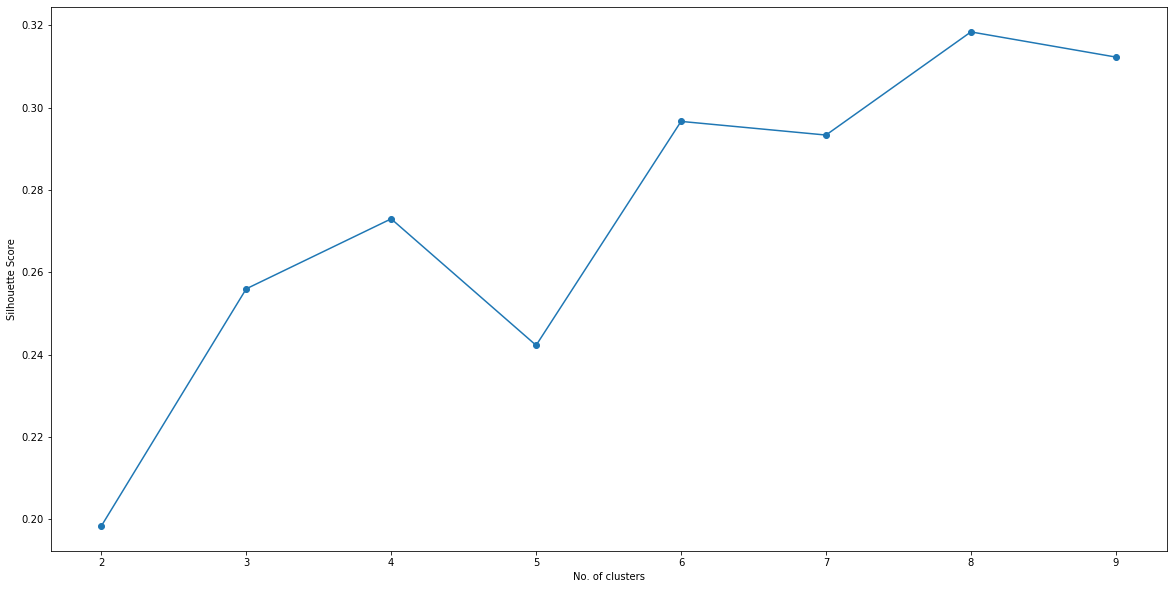

In [28]:
plot(max_range, scores, "No. of clusters", "Silhouette Score")

It looks like 8 is the optimal number of clusters that will ensure that the elements in each cluster are adequately similar and that the elements from different clusters are significantly different.

In [29]:
k_cluster = np.argmax(scores) + 2 # Finds the optimal value
k_cluster

8

Now we can begin to cluster the neighbourhoods.

In [30]:
# Run k-means clustering
auck = auckland_clustering
kmeans = KMeans(n_clusters = k_cluster, init = 'k-means++', random_state = 0).fit(auck)

Let's add the cluster labels to the top 10 venues dataframe...

In [31]:
# Add clustering labels
venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

and merge it with our first dataframe (Neighbourhood_df), that contains the coordinates of each neighbourhood.

In [32]:
auckland_merged = Neighbourhood_df
auckland_merged = auckland_merged.join(venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

print(auckland_merged.shape)
auckland_merged.head()

(198, 14)


,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Airport Oaks,-36.729160,174.708930,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Albany, New Zealand",-37.010493,174.940852,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Alfriston, New Zealand",-36.848399,174.764388,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Algies Bay,-36.863020,174.748580,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,"Arch Hill, New Zealand",-36.847862,174.737085,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Don't worry, it is of no surprise that there are many missing values. Remember that our first dataframe (Neighbourhood_df) has information of all neighbourhoods in Auckland. Don't forget that we only performed the clustering to the neighbourhoods that had bookstores according to our parameters. So let's drop all those rows.

In [33]:
print("Num of rows with missing Cluster Label: ", auckland_merged['Cluster Labels'].isna().sum())

Num of rows with missing Cluster Label:  175


We can convert the cluster labels to integers and sort the dataframe as well.

In [34]:
auckland_merged = auckland_merged[auckland_merged['Cluster Labels'].isna() == False]
auckland_merged['Cluster Labels'] = auckland_merged['Cluster Labels'].astype(int)

auckland_merged = auckland_merged.sort_values(by = ['Cluster Labels'])

print(auckland_merged.shape)
auckland_merged

(23, 14)


,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
161,Rothesay Bay,-36.910653,174.772330,0,Café,Fast Food Restaurant,Park,Bakery,Indian Restaurant,Japanese Restaurant,Gastropub,Chinese Restaurant,Shopping Mall,Planetarium
186,Te Papapa,-36.909430,174.754830,0,Café,Indian Restaurant,Park,Bakery,Chinese Restaurant,Thai Restaurant,Fast Food Restaurant,Japanese Restaurant,Coffee Shop,Supermarket
75,"Hillpark, Auckland",-36.923898,174.755363,0,Café,Fast Food Restaurant,Park,Shopping Mall,Bakery,Grocery Store,Burger Joint,Indian Restaurant,Supermarket,Outdoor Supply Store
10,"Avondale, Auckland",-36.888200,174.740190,1,Café,Chinese Restaurant,Bar,Coffee Shop,Bakery,Gym,Park,Indian Restaurant,Burger Joint,Asian Restaurant
164,"Saint Marys Bay, New Zealand",-36.892970,174.736480,1,Café,Chinese Restaurant,Bar,Indian Restaurant,Coffee Shop,Bakery,Gym,Thai Restaurant,Asian Restaurant,Food & Drink Shop
98,Manukau,-36.890489,174.774960,1,Café,Chinese Restaurant,Thai Restaurant,Gym,Japanese Restaurant,Bar,Park,Ice Cream Shop,Bakery,Burger Joint
114,"Mount Albert, New Zealand",-36.883602,174.754237,1,Café,Japanese Restaurant,Chinese Restaurant,Bar,Gym,Malay Restaurant,Thai Restaurant,Bakery,Coffee Shop,Park
42,"Ellerslie, New Zealand",-36.873070,174.777080,1,Café,Japanese Restaurant,Park,Coffee Shop,Restaurant,Dessert Shop,Bagel Shop,Thai Restaurant,Pizza Place,Bistro
117,Murrays Bay,-36.815421,174.799342,2,Café,Bar,Beach,Scenic Lookout,Movie Theater,Fruit & Vegetable Store,Sushi Restaurant,Supermarket,Bookstore,History Museum
26,"Chatswood, New Zealand",-36.818200,174.800190,2,Café,Scenic Lookout,Beach,Bar,History Museum,Bakery,Performing Arts Venue,Comfort Food Restaurant,Candy Store,Burger Joint


Let's create a map that shows us the locations by type of cluster.

In [35]:
# Create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# Set color scheme for the clusters
x = np.arange(k_cluster)
ys = [i + x + (i*x)**2 for i in range(k_cluster)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# Add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(auckland_merged['Latitude'], auckland_merged['Longitude'], auckland_merged['Neighbourhood'], auckland_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker([lat, lon], radius = 5, popup = label, color = rainbow[cluster-1], fill = True, fill_color = rainbow[cluster-1],
        fill_opacity = 0.7).add_to(map_clusters)
       
map_clusters

Perfect! Now we obtained the information of the relevant neighbourhoods along with their coordinates, number of cluster and most common venues. Also, we have the map of the potential locations to open a new bookstore in Auckland. All that remains is to interpret the information obtained.

### IV. Analysis

It is the moment to examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, we can then assign a name to each cluster.

First of all, you can see that almost all the clusters have as their most popular venue the Cafés. Therefore it would be redundant to consider it for our analysis. We will proceed starting with the second most popular venue.

#### Cluster 1: Diverse Restaurants and Parks

In [36]:
# CLuster 1
auckland_merged.loc[auckland_merged['Cluster Labels'] == 0, auckland_merged.columns[[0] + list(range(4, auckland_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
161,Rothesay Bay,Café,Fast Food Restaurant,Park,Bakery,Indian Restaurant,Japanese Restaurant,Gastropub,Chinese Restaurant,Shopping Mall,Planetarium
186,Te Papapa,Café,Indian Restaurant,Park,Bakery,Chinese Restaurant,Thai Restaurant,Fast Food Restaurant,Japanese Restaurant,Coffee Shop,Supermarket
75,"Hillpark, Auckland",Café,Fast Food Restaurant,Park,Shopping Mall,Bakery,Grocery Store,Burger Joint,Indian Restaurant,Supermarket,Outdoor Supply Store


#### Cluster 2: Asian Cuisine Resturants and Bars

In [37]:
# CLuster 2
auckland_merged.loc[auckland_merged['Cluster Labels'] == 1, auckland_merged.columns[[0] + list(range(4, auckland_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,"Avondale, Auckland",Café,Chinese Restaurant,Bar,Coffee Shop,Bakery,Gym,Park,Indian Restaurant,Burger Joint,Asian Restaurant
164,"Saint Marys Bay, New Zealand",Café,Chinese Restaurant,Bar,Indian Restaurant,Coffee Shop,Bakery,Gym,Thai Restaurant,Asian Restaurant,Food & Drink Shop
98,Manukau,Café,Chinese Restaurant,Thai Restaurant,Gym,Japanese Restaurant,Bar,Park,Ice Cream Shop,Bakery,Burger Joint
114,"Mount Albert, New Zealand",Café,Japanese Restaurant,Chinese Restaurant,Bar,Gym,Malay Restaurant,Thai Restaurant,Bakery,Coffee Shop,Park
42,"Ellerslie, New Zealand",Café,Japanese Restaurant,Park,Coffee Shop,Restaurant,Dessert Shop,Bagel Shop,Thai Restaurant,Pizza Place,Bistro


#### Cluster 3: Scenic Lookout and Cultural Places

In [38]:
# CLuster 3
auckland_merged.loc[auckland_merged['Cluster Labels'] == 2, auckland_merged.columns[[0] + list(range(4, auckland_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
117,Murrays Bay,Café,Bar,Beach,Scenic Lookout,Movie Theater,Fruit & Vegetable Store,Sushi Restaurant,Supermarket,Bookstore,History Museum
26,"Chatswood, New Zealand",Café,Scenic Lookout,Beach,Bar,History Museum,Bakery,Performing Arts Venue,Comfort Food Restaurant,Candy Store,Burger Joint
192,Unsworth Heights,Café,Scenic Lookout,Beach,Bar,History Museum,Bakery,Performing Arts Venue,Comfort Food Restaurant,Candy Store,Burger Joint


#### Cluster 4: Fast Food Restaurants and Diverse Stores

In [39]:
# CLuster 4
auckland_merged.loc[auckland_merged['Cluster Labels'] == 3, auckland_merged.columns[[0] + list(range(4, auckland_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
115,Mount Eden,Café,Fast Food Restaurant,Burger Joint,Department Store,Electronics Store,Grocery Store,Clothing Store,Malay Restaurant,Bar,Shopping Mall
140,Pakuranga Heights,Café,Fast Food Restaurant,Grocery Store,Department Store,Clothing Store,Pizza Place,Train Station,Supermarket,Burger Joint,Malay Restaurant
169,"Southdown, New Zealand",Café,Fast Food Restaurant,Pizza Place,Grocery Store,Clothing Store,Electronics Store,Supermarket,Athletics & Sports,Train Station,Department Store
180,Takapuna,Café,Pizza Place,Park,Fast Food Restaurant,Burger Joint,Athletics & Sports,Train Station,Coffee Shop,Department Store,Supermarket


#### Cluster 5: Fast Food Restaurant Mostly

In [40]:
# CLuster 5
auckland_merged.loc[auckland_merged['Cluster Labels'] == 4, auckland_merged.columns[[0] + list(range(4, auckland_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,Brookby,Café,Fast Food Restaurant,Beach,Coffee Shop,Neighborhood,Burger Joint,Japanese Restaurant,Supermarket,Indian Restaurant,Bar
168,Shelly Park,Café,Fast Food Restaurant,Burger Joint,Clothing Store,Grocery Store,Pizza Place,Electronics Store,Bar,Athletics & Sports,Furniture / Home Store


#### Cluster 6: Asian Cuisine Restaurants Mostly

In [41]:
# CLuster 6
auckland_merged.loc[auckland_merged['Cluster Labels'] == 5, auckland_merged.columns[[0] + list(range(4, auckland_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
70,"Herne Bay, New Zealand",Vietnamese Restaurant,Chinese Restaurant,Japanese Restaurant,Market,Café,Department Store,Fast Food Restaurant,Gym,Mongolian Restaurant,Basketball Court


#### Cluster 7: Parks and Diverse Stores

In [42]:
# CLuster 7
auckland_merged.loc[auckland_merged['Cluster Labels'] == 6, auckland_merged.columns[[0] + list(range(4, auckland_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
95,Māngere,Café,Park,Fast Food Restaurant,Grocery Store,Farm,Bookstore,Train Station,Clothing Store,Outdoor Supply Store,Shopping Mall
31,"Cockle Bay, New Zealand",Café,Park,Clothing Store,Grocery Store,Fast Food Restaurant,Farm,Rental Car Location,Juice Bar,Sporting Goods Shop,Motel


#### Cluster 8: Beach and Harbor

In [43]:
# CLuster 8
auckland_merged.loc[auckland_merged['Cluster Labels'] == 7, auckland_merged.columns[[0] + list(range(4, auckland_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
35,"Devonport, New Zealand",Café,Beach,Harbor / Marina,Bar,Scenic Lookout,Restaurant,Supermarket,Boat or Ferry,Bookstore,Sporting Goods Shop
34,"Dannemora, New Zealand",Café,Hotel,Bar,Beach,Harbor / Marina,Restaurant,Coffee Shop,Pizza Place,Turkish Restaurant,Japanese Restaurant
129,Ōpaheke,Café,Park,Beach,Coffee Shop,Italian Restaurant,Fish & Chips Shop,Bar,Harbor / Marina,Comfort Food Restaurant,Deli / Bodega


### V. Conclusion

After conducting the K-mean clustering in Auckland's neighbourhoods and analyzing each cluster, we can observe that Cluster 3 'Scenic Lookout and Cultural Places' seems to be the most appropriate place to open a new bookstore. The reason being that these neighbourhoods seem to be located in an attractive place to the kind of costumers who frequent bookstores given that it contains places of cultural interest and scenic lookouts where they may read. 